# TODO:
1. Update aileron.stl to 4 separate aileron files that are placed in the correct positions, currently only one aileron is in correct position and all other Aileron.stl file placements overlap [DONE]
2. Test with two ailerons (left and right), see if they are in correct positions [DONE]
3. Define them as joints in rocket.urdf, apply changes to update_meshcat() as shown in Copilot Chat shown below [IP]
4. Test if these ailerons are controllable 
5. Add other 2 ailerons in following similar process, define them in ae353_zag.py file in meshcat_init() and meshcat_update()
6. Test if these ailerons are controllable


**Question**: if i define the aileron as joints, how can i control them if meshcat doesn't do any updates on it manually?

Great question!  
When you define the ailerons as joints in your URDF, **you control them through PyBullet, not Meshcat**.

### How it works:

- **PyBullet** simulates the physics and joint positions.
- **Meshcat** is just a visualizer. If you want Meshcat to show the ailerons moving, you must update their transforms in your `meshcat_update` method, using the joint states from PyBullet.

---

## How to Control Aileron Joints in PyBullet

1. **Set the joint positions in PyBullet:**
   ```python
   self.bullet_client.setJointMotorControl2(
       self.robot_id,
       jointIndex,  # index of the aileron joint
       self.bullet_client.POSITION_CONTROL,
       targetPosition=desired_angle
   )
   ```
   - You can get the joint indices by name using `getJointInfo`.

2. **Update Meshcat visualization:**
   - In your `meshcat_update` method, get the joint state from PyBullet:
     ```python
     joint_state = self.bullet_client.getJointState(self.robot_id, jointIndex)
     joint_angle = joint_state[0]
     ```
   - Use this angle to set the transform of the aileron mesh in Meshcat:
     ```python
     # Compute the transform for the aileron based on joint_angle
     self.vis['robot']['aileron-right'].set_transform(...)
     ```

---

## Summary Table

| What controls the joint? | How to update?                      |
|------------------------- |-------------------------------------|
| PyBullet                 | `setJointMotorControl2`             |
| Meshcat                  | Use joint state to set transform    |

---

**In short:**  
- PyBullet controls the joint angles.
- Meshcat only visualizes; you must update the transforms in your code using the joint angles from PyBullet.

Let me know if you want a code example for your specific setup!

In [7]:
# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sympy import *

# This is my own script (it is an interface to the pybullet simulator)
import rocket_424

simulator = rocket_424.Simulator(
    display=True,  # Whether or not to show the simulation window. The simulation will
    # run much faster if you do not show this window, so set display to
    # False if you want to run many simulations to collect results.
)

simulator.camera_catview()

argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [2]:
def LQR(A, B, Q, R):

    # Convert symbolic matrices to numerical arrays
    A = lambdify((), A)()
    B = lambdify((), B)()
    Q = lambdify((), Q)()
    R = lambdify((), R)()
    # Solve the continuous-time algebraic Riccati equation (CARE)
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)
    # Compute the LQR gain
    K = scipy.linalg.inv(R) @ B.T @ P
    return K


In [3]:
def get_AB():
    p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z = symbols(
        "p_x p_y p_z psi theta phi v_x v_y v_z w_x w_y w_z"
    )

    delta_l, delta_r = symbols("delta_l delta_r")

    f = Matrix(
        [
            [
                v_x * sin(psi) * cos(theta)
                + v_y * (sin(phi) * sin(psi) * sin(theta) + cos(phi) * cos(psi))
                + v_z * (-sin(phi) * cos(psi) + sin(psi) * sin(theta) * cos(phi))
            ],
            [w_y * sin(phi) / cos(theta) + w_z * cos(phi) / cos(theta)],
            [w_y * cos(phi) - w_z * sin(phi)],
            [w_x + w_y * sin(phi) * tan(theta) + w_z * cos(phi) * tan(theta)],
            [
                1.0 * v_y * w_z
                - 1.0 * v_z * w_y
                - 9.81 * sin(theta)
                - 0.190880358974359
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    0.0009 * (delta_l / 2 + delta_r / 2) ** 2
                    + 1.10592 * (atan(v_z / v_x) + 0.0416666666666667) ** 2
                    + 0.02
                )
                / sqrt(1 + v_z**2 / v_x**2)
                + 0.190880358974359
                * v_z
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    0.15 * delta_l
                    + 0.15 * delta_r
                    + 0.36322 * w_y / sqrt(v_x**2 + v_y**2 + v_z**2)
                    + 4.8 * atan(v_z / v_x)
                    + 0.2
                )
                / (v_x * sqrt(1 + v_z**2 / v_x**2))
            ],
            [
                -1.0 * v_x * w_z
                + 1.0 * v_z * w_x
                - 0.0152704287179487
                * (v_x**2 + v_y**2 + v_z**2)
                * asin(v_y / sqrt(v_x**2 + v_y**2 + v_z**2))
                + 9.81 * sin(phi) * cos(theta)
            ],
            [
                1.0 * v_x * w_y
                - 1.0 * v_y * w_x
                + 9.81 * cos(phi) * cos(theta)
                - 0.190880358974359
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    0.15 * delta_l
                    + 0.15 * delta_r
                    + 0.36322 * w_y / sqrt(v_x**2 + v_y**2 + v_z**2)
                    + 4.8 * atan(v_z / v_x)
                    + 0.2
                )
                / sqrt(1 + v_z**2 / v_x**2)
                - 0.190880358974359
                * v_z
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    0.0009 * (delta_l / 2 + delta_r / 2) ** 2
                    + 1.10592 * (atan(v_z / v_x) + 0.0416666666666667) ** 2
                    + 0.02
                )
                / (v_x * sqrt(1 + v_z**2 / v_x**2))
            ],
            [
                -0.0044004422851945 * w_x * w_y
                + 0.502237146150199 * w_y * w_z
                - 8.71939489844095 * w_y * (-0.0015 * w_x + 0.1712 * w_z)
                + 0.0763965674512934 * w_y * (0.1147 * w_x - 0.0015 * w_z)
                + 0.0323579821372602
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    -0.002 * delta_l
                    + 0.002 * delta_r
                    - 0.0156464 * w_x / sqrt(v_x**2 + v_y**2 + v_z**2)
                    - 0.0064008 * w_z / sqrt(v_x**2 + v_y**2 + v_z**2)
                    + 0.008 * asin(v_y / sqrt(v_x**2 + v_y**2 + v_z**2))
                )
                + 3.69312436126596
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    0.09 * delta_l
                    - 0.09 * delta_r
                    - 0.32004 * w_x / sqrt(v_x**2 + v_y**2 + v_z**2)
                    + 0.021336 * w_z / sqrt(v_x**2 + v_y**2 + v_z**2)
                    - 0.1 * asin(v_y / sqrt(v_x**2 + v_y**2 + v_z**2))
                )
            ],
            [
                17.3611111111111 * w_x * (-0.0015 * w_x + 0.1712 * w_z)
                - 17.3611111111111 * w_z * (0.1147 * w_x - 0.0015 * w_z)
                + 1.70702714361111
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    -0.175 * delta_l
                    - 0.175 * delta_r
                    - 0.29718 * w_y / sqrt(v_x**2 + v_y**2 + v_z**2)
                    - 0.6 * atan(v_z / v_x)
                    - 0.02
                )
            ],
            [
                -0.336487153407873 * w_x * w_y
                + 0.0044004422851945 * w_y * w_z
                - 0.0763965674512934 * w_y * (-0.0015 * w_x + 0.1712 * w_z)
                + 5.84179085777557 * w_y * (0.1147 * w_x - 0.0015 * w_z)
                + 2.47430703409583
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    -0.002 * delta_l
                    + 0.002 * delta_r
                    - 0.0156464 * w_x / sqrt(v_x**2 + v_y**2 + v_z**2)
                    - 0.0064008 * w_z / sqrt(v_x**2 + v_y**2 + v_z**2)
                    + 0.008 * asin(v_y / sqrt(v_x**2 + v_y**2 + v_z**2))
                )
                + 0.0323579821372602
                * (v_x**2 + v_y**2 + v_z**2)
                * (
                    0.09 * delta_l
                    - 0.09 * delta_r
                    - 0.32004 * w_x / sqrt(v_x**2 + v_y**2 + v_z**2)
                    + 0.021336 * w_z / sqrt(v_x**2 + v_y**2 + v_z**2)
                    - 0.1 * asin(v_y / sqrt(v_x**2 + v_y**2 + v_z**2))
                )
            ],
        ]
    )


    A: Matrix = Matrix(f).jacobian([p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])

    A_v = A.subs(
        (
            [p_y, 0],
            [psi, 0],
            [theta, -0.0996686],
            [phi, 0],
            [v_x, 15],
            [v_y, 0],
            [v_z, 1.5],
            [w_x, 0],
            [w_y, 0],
            [w_z, 0],
            [delta_r, 0],
            [delta_l, 0],
        )
    )

    B: Matrix = Matrix(f).jacobian([delta_r, delta_l])

    B_v = B.subs(
        (
            [p_y, 0],
            [psi, 0],
            [theta, -0.0996686],
            [phi, 0],
            [v_x, 15],
            [v_y, 0],
            [v_z, 1.5],
            [w_x, 0],
            [w_y, 0],
            [w_z, 0],
            [delta_r, 0],
            [delta_l, 0],
        )
    )
    return A_v, B_v

In [ ]:
class Controller:
    def __init__(self, Q, R):
        self.Q = Q
        self.R = R
        self.A, self.B = get_AB()
        self.K = Matrix(LQR(self.A, self.B, self.Q, self.R))

    def reset(self):
        pass

    def run(
        self,
        t,  # current time
        p_x,
        p_y,
        p_z,  # components of position (+z is down!)
        psi,
        theta,
        phi,  # yaw, pitch, and roll angles
        v_x,
        v_y,
        v_z,  # components of linear velocity in the body frame
        w_x,
        w_y,
        w_z,  # components of angular velocity in the body frame
    ):

        # FIXME: replace the following lines
        x = np.array([p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
        x_d = -self.K @ x
        delta_r = x_d[0]  # right elevon deflection angle (positive is down)
        delta_l = x_d[1]  # left elevon deflection angle (positive is down)
        return delta_r, delta_l, delta_r, delta_l

In [5]:
# Q = 0.1 * diag(150, 150, 150, 150, 5, 150, 75, 150, 150, 150)
# R = diag(1, 1)
# controller = Controller(Q, R)

# def iterate(num_iterations):
#     for i in range(num_iterations):
#         controller = Controller(Q, R)
#         simulator.reset()
#         data = simulator.run(controller, maximum_time=25.0)
#         has_landed = simulator.has_landed()
#         if has_landed:
#             print(f"Iteration {i}: The aircraft landed.")
#             break
#         else:
#             print(f"Iteration {i}: The aircraft did not land.")

In [6]:
Q = 0.1 * diag(150, 150, 150, 150, 5, 150, 75, 150, 150, 150)
R = diag(1, 1)
num_iterations = 50

# for i in range(num_iterations):
#     controller = Controller(Q, R)
#     simulator.reset()
#     data = simulator.run(controller, maximum_time=25.0)
#     has_landed = simulator.has_landed()
#     if has_landed:
#         print(f"Iteration {i}: The aircraft landed.")
#         break
#     else:
#         print(f"Iteration {i}: The aircraft did not land.")

controller = Controller(Q, R)

# simulator.reset(
#     initial_conditions={
#         "p_x": 0.0,
#         "p_y": 0.0,
#         "p_z": 0.0,
#         "psi": 0.0,
#         "theta": 0.0,
#         "phi": 0.0,
#         "v_x": 5.0,
#         "v_y": 0.0,
#         "v_z": 0.0,
#         "w_x": 0.0,
#         "w_y": 0.0,
#         "w_z": 0.0,
#     }
# )

simulator.reset()
controller.reset()

In [7]:
Q = 0.1 * diag(150, 150, 150, 150, 5, 150, 75, 150, 150, 150)
R = diag(1, 1)
num_iterations = 50

# for i in range(num_iterations):
#     controller = Controller(Q, R)
#     simulator.reset()
#     data = simulator.run(controller, maximum_time=25.0)
#     has_landed = simulator.has_landed()
#     if has_landed:
#         print(f"Iteration {i}: The aircraft landed.")
#         break
#     else:
#         print(f"Iteration {i}: The aircraft did not land.")

controller = Controller(Q, R)

# simulator.reset(
#     initial_conditions={
#         "p_x": 0.0,
#         "p_y": 0.0,
#         "p_z": 0.0,
#         "psi": 0.0,
#         "theta": 0.0,
#         "phi": 0.0,
#         "v_x": 5.0,
#         "v_y": 0.0,
#         "v_z": 0.0,
#         "w_x": 0.0,
#         "w_y": 0.0,
#         "w_z": 0.0,
#     }
# )

simulator.reset()
controller.reset()
data = simulator.run(
    controller,  # <-- required (an instance of your Controller class)
    maximum_time=25.0,  # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,  # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

has_landed = simulator.has_landed()
if has_landed:
    print("The aircraft landed.")
else:
    print("The aircraft did not land.")


KeyboardInterrupt: 

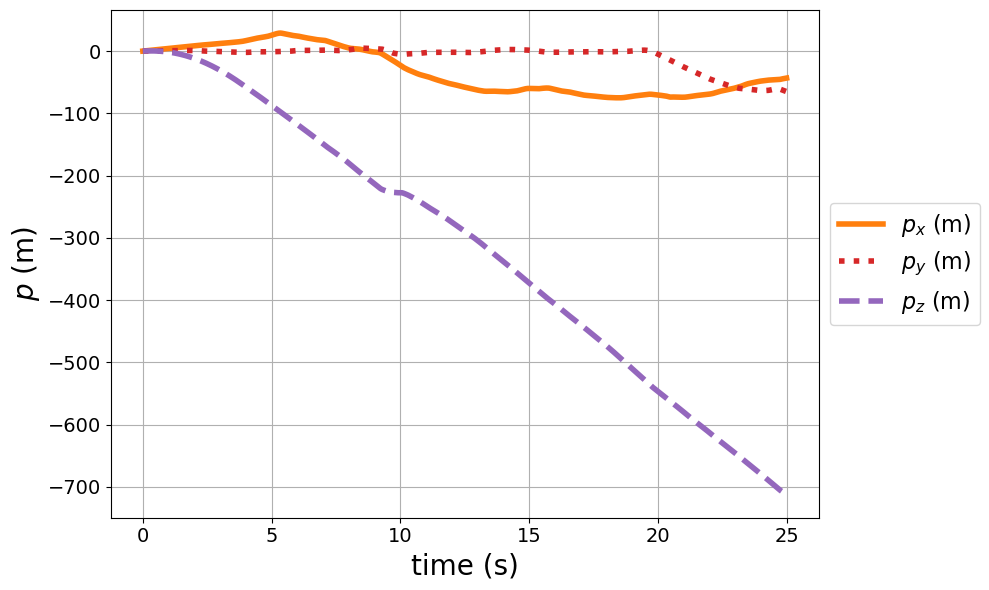

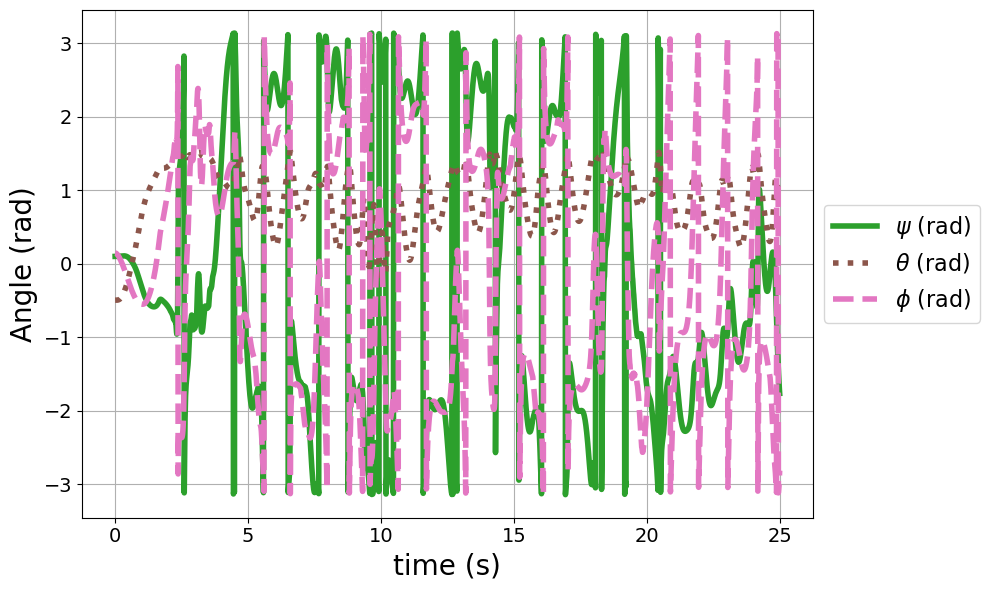

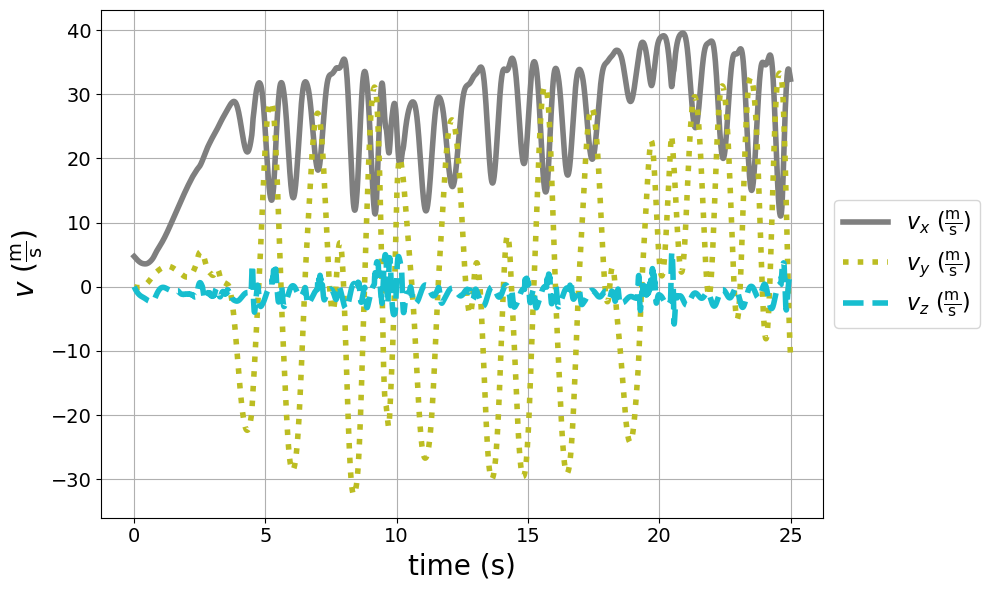

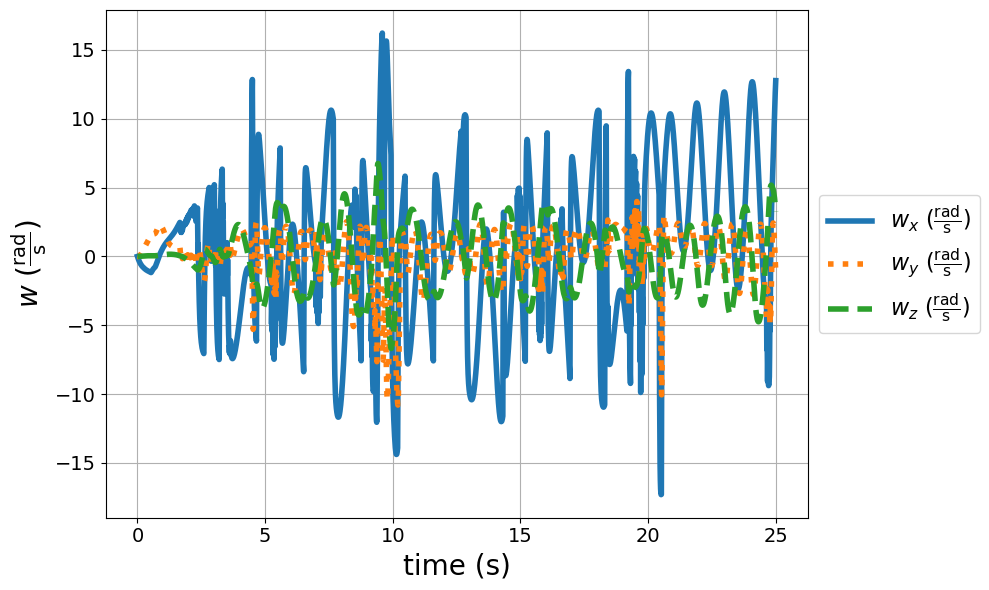

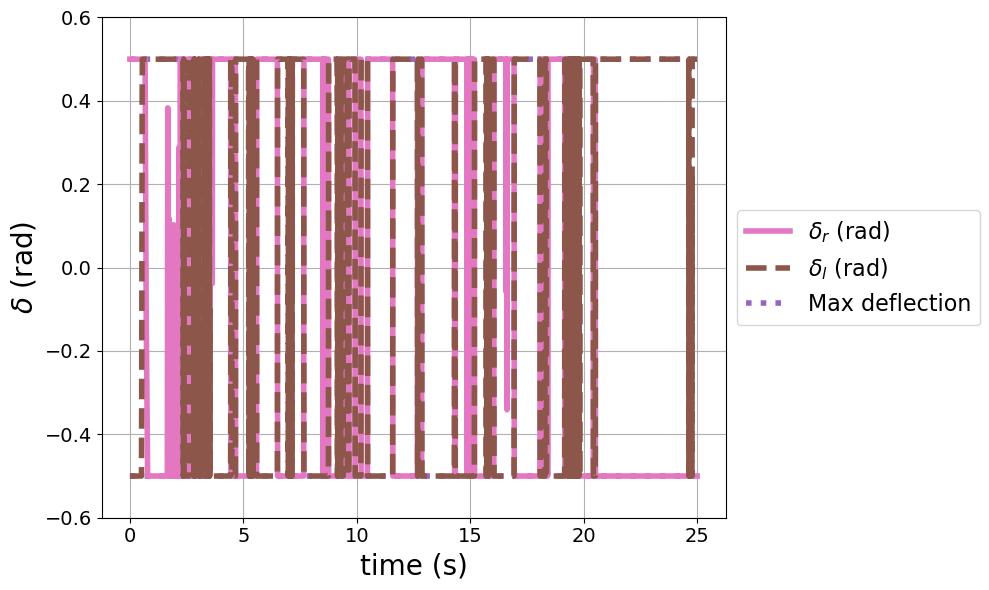

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is a dictionary containing your data
# Example: data = {"t": ..., "p_x": ..., "p_y": ..., "p_z": ..., "psi": ..., "theta": ..., "phi": ..., "v_x": ..., "v_y": ..., "v_z": ..., "w_x": ..., "w_y": ..., "w_z": ..., "delta_r": ..., "delta_l": ...}

# Plot position
fig_pos, ax_pos = plt.subplots(figsize=(10, 6))
ax_pos.plot(data["t"], data["p_x"], label="$p_x$ (m)", linewidth=4, color="C1", linestyle="solid")
ax_pos.plot(data["t"], data["p_y"], label="$p_y$ (m)", linewidth=4, color="C3", linestyle="dotted")
ax_pos.plot(data["t"], data["p_z"], label="$p_z$ (m)", linewidth=4, color="C4", linestyle="--")
ax_pos.grid()
ax_pos.set_ylabel("$p$ (m)", fontsize=20)
ax_pos.set_xlabel("time (s)", fontsize=20)
ax_pos.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_pos.tick_params(labelsize=14)
fig_pos.tight_layout()
fig_pos.savefig("position_plot.png", facecolor="white", transparent=False)

# Plot orientation
fig_ori, ax_ori = plt.subplots(figsize=(10, 6))
ax_ori.plot(data["t"], data["psi"], label="$\\psi$ (rad)", linewidth=4, color="C2", linestyle="solid")
ax_ori.plot(data["t"], data["theta"], label="$\\theta$ (rad)", linewidth=4, color="C5", linestyle="dotted")
ax_ori.plot(data["t"], data["phi"], label="$\\phi$ (rad)", linewidth=4, color="C6", linestyle="--")
ax_ori.grid()
ax_ori.set_ylabel("Angle (rad)", fontsize=20)
ax_ori.set_xlabel("time (s)", fontsize=20)
ax_ori.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_ori.tick_params(labelsize=14)
fig_ori.tight_layout()
fig_ori.savefig("orientation_plot.png", facecolor="white", transparent=False)

# Plot linear velocity
fig_linvel, ax_linvel = plt.subplots(figsize=(10, 6))
ax_linvel.plot(data["t"], data["v_x"], label="$v_x\\ (\\frac {\\text{m}} {\\text{s}})$", linewidth=4, color="C7", linestyle="solid")
ax_linvel.plot(data["t"], data["v_y"], label="$v_y\\ (\\frac {\\text{m}} {\\text{s}})$", linewidth=4, color="C8", linestyle="dotted")
ax_linvel.plot(data["t"], data["v_z"], label="$v_z\\ (\\frac {\\text{m}} {\\text{s}})$", linewidth=4, color="C9", linestyle="--")
ax_linvel.grid()
ax_linvel.set_ylabel("$v\\ (\\frac {\\text{m}} {\\text{s}})$", fontsize=20)
ax_linvel.set_xlabel("time (s)", fontsize=20)
ax_linvel.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_linvel.tick_params(labelsize=14)
fig_linvel.tight_layout()
fig_linvel.savefig("linear_velocity_plot.png", facecolor="white", transparent=False)

# Plot angular velocity
fig_angvel, ax_angvel = plt.subplots(figsize=(10, 6))
ax_angvel.plot(data["t"], data["w_x"], label="$w_x\\ (\\frac {\\text{rad}} {\\text{s}})$", linewidth=4, color="C10", linestyle="solid")
ax_angvel.plot(data["t"], data["w_y"], label="$w_y\\ (\\frac {\\text{rad}} {\\text{s}})$", linewidth=4, color="C11", linestyle="dotted")
ax_angvel.plot(data["t"], data["w_z"], label="$w_z\\ (\\frac {\\text{rad}} {\\text{s}})$", linewidth=4, color="C12", linestyle="--")
ax_angvel.grid()
ax_angvel.set_ylabel("$w\\ (\\frac {\\text{rad}} {\\text{s}})$", fontsize=20)
ax_angvel.set_xlabel("time (s)", fontsize=20)
ax_angvel.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_angvel.tick_params(labelsize=14)
fig_angvel.tight_layout()
fig_angvel.savefig("angular_velocity_plot.png", facecolor="white", transparent=False)

# Plot elevon deflection angles
fig_delta, ax_delta = plt.subplots(figsize=(10, 6))
ax_delta.plot(data["t"], data["delta_r"], label="$\\delta_r$ (rad)", linewidth=4, color="C16", linestyle="solid")
ax_delta.plot(data["t"], data["delta_l"], label="$\\delta_l$ (rad)", linewidth=4, color="C15", linestyle="--")
ax_delta.plot(data["t"], -np.ones_like(data["t"]) * simulator.maximum_elevon_deflection, ":", linewidth=4, color="C4", zorder=0, label="Max deflection")
ax_delta.plot(data["t"], np.ones_like(data["t"]) * simulator.maximum_elevon_deflection, ":", linewidth=4, color="C4", zorder=0)
ax_delta.grid()
ax_delta.set_ylabel("$\\delta$ (rad)", fontsize=20)
ax_delta.set_xlabel("time (s)", fontsize=20)
ax_delta.legend(fontsize=16, loc="center left", bbox_to_anchor=(1, 0.5))
ax_delta.tick_params(labelsize=14)
ax_delta.set_ylim(-1.2 * simulator.maximum_elevon_deflection, 1.2 * simulator.maximum_elevon_deflection)
fig_delta.tight_layout()
fig_delta.savefig("elevon_deflection_plot.png", facecolor="white", transparent=False)